In [1]:
import pandas as pd
from copy import deepcopy
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
gpp.set_aesthetics(context = 'paper')

In [5]:
#read in z-scored external datasets

NunezCleanData = pd.read_csv('../../Data/externalData/Nunez2021Cleaned.csv')
GilbertRicinCleanData = pd.read_csv('../../Data/externalData/Gilbert2014Cleaned.csv')

#read in z-scored internal datasets
file_path = '../../Data/primaryLibrary/'
annot_guide_lfcs_A549_Kox1 = pd.read_csv(file_path + 'A549_Kox1_zscored.csv')
annot_guide_lfcs_A549_Kox1 = annot_guide_lfcs_A549_Kox1[annot_guide_lfcs_A549_Kox1.Category.isin(['Essential', 'Non-essential'])]

annot_guide_lfcs_A549_Zim3 = pd.read_csv(file_path +  'A549_Zim3_zscored.csv')
annot_guide_lfcs_A549_Zim3 = annot_guide_lfcs_A549_Zim3[annot_guide_lfcs_A549_Zim3.Category.isin(['Essential', 'Non-essential'])]

annot_guide_lfcs_HCT116_Kox1 = pd.read_csv(file_path +  'HCT116_Kox1_zscored.csv')
annot_guide_lfcs_HCT116_Kox1 = annot_guide_lfcs_HCT116_Kox1[annot_guide_lfcs_HCT116_Kox1.Category.isin(['Essential', 'Non-essential'])]

annot_guide_lfcs_HCT116_Zim3 = pd.read_csv(file_path +  'HCT116_Zim3_zscored.csv')
annot_guide_lfcs_HCT116_Zim3 = annot_guide_lfcs_HCT116_Zim3[annot_guide_lfcs_HCT116_Zim3.Category.isin(['Essential', 'Non-essential'])]

annot_guide_lfcs_A549_Kox1['Domain'] = 'Kox1'
annot_guide_lfcs_A549_Zim3['Domain'] = 'Zim3'
annot_guide_lfcs_HCT116_Kox1['Domain'] = 'Kox1'
annot_guide_lfcs_HCT116_Zim3['Domain'] = 'Zim3'

InHouseCleanData = pd.concat([annot_guide_lfcs_A549_Kox1, annot_guide_lfcs_A549_Zim3, annot_guide_lfcs_HCT116_Kox1, annot_guide_lfcs_HCT116_Zim3])

#add extra information to in-house data from design file
ess_noness = pd.read_csv('../../Data/primaryLibrary/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv')
ess_noness['chromosome'] = ess_noness['Reference Sequence'].apply(lambda x: int(x.split("NC_")[1].split(".")[0]) if pd.notnull(x) else x)

ess_noness = ess_noness[['Target Gene Symbol','Target Gene ID','Category','chromosome','sgRNA Sequence', 
           'sgRNA Context Sequence', 'TSS Position', 
       'sgRNA \'Cut\' Site TSS Offset', 'sgRNA \'Cut\' Position', 
            'Strand of Target','Strand of sgRNA', 'Orientation',
            'On-Target Ruleset','On-Target Efficacy Score']]
InHouseCleanData = pd.merge(InHouseCleanData, ess_noness)
InHouseCleanData = InHouseCleanData[InHouseCleanData.Category == 'Essential']

In [6]:
#standardize column names across datasets
NunezCleanData = NunezCleanData[['Target Gene Symbol', 'context_seq','strand']].rename(columns = {'context_seq': 'sgRNA Context Sequence',
                                                                                                 'strand': 'Strand of sgRNA'})
NunezCleanData['DataSet'] = 'Nunez'
NunezCleanData['ModifiedGuideStrand'] = NunezCleanData['Strand of sgRNA'].replace({'-':'+','+':'-'})

GilbertRicinCleanData = GilbertRicinCleanData[['Target Gene Symbol', 'context seq','strand targeted']].rename(columns = {'context seq': 'sgRNA Context Sequence',
                                                                                                'strand targeted': 'Strand of sgRNA'})
GilbertRicinCleanData['DataSet'] = 'Gilbert'
GilbertRicinCleanData['ModifiedGuideStrand'] = GilbertRicinCleanData['Strand of sgRNA'].replace({'-':'+','+':'-'})

InHouseCleanData = InHouseCleanData[['Target Gene Symbol', 'sgRNA Context Sequence','Strand of sgRNA']]
InHouseCleanData['DataSet'] = 'InHouse'

InHouseCleanData['ModifiedGuideStrand'] = InHouseCleanData['Strand of sgRNA']

#combine datasets
combinedDataStrand = pd.concat([NunezCleanData,GilbertRicinCleanData,InHouseCleanData]).drop_duplicates()
combinedDataStrand['sgRNA Context Sequence'] = combinedDataStrand['sgRNA Context Sequence'].str.upper()
combinedDataStrand

,Target Gene Symbol,sgRNA Context Sequence,Strand of sgRNA,DataSet,ModifiedGuideStrand
0,ACTR6,TGCTTCGAGCACATAGAGGGATCTGGGCCC,+,Nunez,-
1,ACTR6,CTGCTTCGAGCACATAGAGGGATCTGGGCC,+,Nunez,-
2,ACTR6,GTCCACCTGCTTCGAGCACATAGAGGGATC,+,Nunez,-
3,ACTR6,GGTCCACCTGCTTCGAGCACATAGAGGGAT,+,Nunez,-
4,ACTR6,GGGCTAGACTCTGTCACCTCCGAGGGGTCC,+,Nunez,-
...,...,...,...,...,...
423895,TXNL4A,GCGGGCGGGACCGGATTTCGTCCGTGGGCC,-,InHouse,-
423896,TEDC1,CAGGGGCCAGGGGCCGGCCGCGCTGGGGTC,+,InHouse,+
423899,SNUPN,GCGTGGGCGGGGCCTGGGGCGGGTCGGACT,-,InHouse,-
423900,SNUPN,GGAGGGTGGAGCGTGGGCGGGGCCTGGGGC,-,InHouse,-


In [7]:
NewDatasetCombine_strand = pd.merge(NewDatasetCombine,combinedDataStrand)

NameError: name 'NewDatasetCombine' is not defined

In [31]:
NewDatasetCombine_strand['orginal phenotype'] = NewDatasetCombine_strand['Phenotype scores-ave_Rep1_Rep2'].combine_first(NewDatasetCombine_strand['z_scored_avg_lfc']).combine_first(NewDatasetCombine_strand['rhoSignChangedAndAvged'])


In [32]:
NewDatasetCombine_strand['Orientation'] = NewDatasetCombine_strand['Strand of Target'] + NewDatasetCombine_strand['ModifiedGuideStrand']


In [33]:
NewDatasetCombine_strand.groupby(['Target Gene Symbol'])['Orientation'].value_counts()

Target Gene Symbol  Orientation
AATF                ++             665
                    +-             575
ACTR6               +-             115
                    ++              97
AFG3L2              -+             141
                                  ... 
ZNF574              +-             103
ZNF830              +-             102
                    ++              91
ZNHIT6              --             121
                    -+              45
Name: count, Length: 938, dtype: int64

In [34]:
NewDatasetCombine_strand['Target Gene Symbol'].value_counts()

Target Gene Symbol
RRM2       2195
TEDC1      2057
MROH6      2017
YY1        1985
DNLZ       1979
           ... 
MED18        70
TRMT10C      69
MRPL35       60
NIP7          9
SNW1          9
Name: count, Length: 469, dtype: int64

In [35]:
NewDatasetCombine_strand_avg = NewDatasetCombine_strand.groupby(['Target Gene Symbol',
                                                                 'sgRNA Context Sequence',
                                                                 'Orientation','DataSet'])['orginal phenotype'].mean().reset_index()
NewDatasetCombine_strand_avg

,Target Gene Symbol,sgRNA Context Sequence,Orientation,DataSet,orginal phenotype
0,AATF,AAAACTAAGTTGGAGACTGATGGAAGGATT,++,InHouse,-1.672186
1,AATF,AAACTTGGTGCTCGGCTGGATGGGCGGAAC,++,InHouse,-3.228927
2,AATF,AAAGAAGCCGAAGCCCTCCTCCCGAGGCCG,+-,InHouse,-5.333442
3,AATF,AAAGCATAGCGTAGCCGTGGCCCACGGTGG,+-,InHouse,-1.189932
4,AATF,AAAGCGATTGTGTCTTTCCGTGTGCGGGGT,++,InHouse,0.027726
...,...,...,...,...,...
121146,ZNHIT6,TTTAATGGTTAACACAGATTAGGGTGGGTT,--,Nunez,-0.006481
121147,ZNHIT6,TTTACGGCTCTGCGGAGGCCCTGCCGGATT,-+,Nunez,-0.006145
121148,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,--,Nunez,-0.012569
121149,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,--,Nunez,-0.019812


In [11]:
def mann_whitney_u_per_gene(df):
    results = []
    
    # Group by gene
    grouped = df.groupby('Target Gene Symbol')
    
    for gene, group in grouped:
        Orientation = group['Orientation'].unique()
        
        if len(Orientation) == 2:
            # Extract metrics for both drugs
            metrics_Orientation1 = group[group['Orientation'] == Orientation[0]]['orginal phenotype']
            metrics_Orientation2 = group[group['Orientation'] == Orientation[1]]['orginal phenotype']
            if (len(metrics_Orientation1) >= 10) & (len(metrics_Orientation2) >= 10):
                # Perform Mann-Whitney U test
                stat, p_value = mannwhitneyu(metrics_Orientation1, 
                                             metrics_Orientation2, 
                                             alternative='two-sided')
                results.append({'gene': gene, 
                                'metrics_Orientation1': Orientation[0], 
                                'metrics_Orientation2': Orientation[1], 
                                'p_value': p_value})
            else:
                print(f'{gene} does not satisify the sample size')
        else:
            results.append({'gene': gene, 'metrics_Orientation1': None, 
                            'metrics_Orientation2': None, 'p_value': None})
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_df['-log10(p_value)'] = -np.log10(results_df['p_value'])
    return results_df


In [21]:
results_nunez = mann_whitney_u_per_gene(NewDatasetCombine_strand[NewDatasetCombine_strand.DataSet == 'Nunez'])
results_nunez['Dataset'] = 'Nunez'
results_gilbert = mann_whitney_u_per_gene(NewDatasetCombine_strand[NewDatasetCombine_strand.DataSet == 'Gilbert'])
results_gilbert['Dataset'] = 'Gilbert'

results_inhouseA549Kox1 = mann_whitney_u_per_gene(NewDatasetCombine_strand[(NewDatasetCombine_strand.DataSet == 'InHouse') &
                                                                           (NewDatasetCombine_strand.Domain == 'Kox1') &
                                                                          (NewDatasetCombine_strand.condition == 'A549')])
results_inhouseA549Kox1['Dataset'] = 'InHouse A549 Kox1'


NIP7 does not satisify the sample size
SNW1 does not satisify the sample size


In [22]:
results_inhouseA549Zim3 = mann_whitney_u_per_gene(NewDatasetCombine_strand[(NewDatasetCombine_strand.DataSet == 'InHouse') &
                                                                           (NewDatasetCombine_strand.Domain == 'Zim3') &
                                                                          (NewDatasetCombine_strand.condition == 'A549')])
results_inhouseA549Zim3['Dataset'] = 'InHouse A549 Zim3'


In [23]:
results_inhouseHCT116Kox1 = mann_whitney_u_per_gene(NewDatasetCombine_strand[(NewDatasetCombine_strand.DataSet == 'InHouse') &
                                                                           (NewDatasetCombine_strand.Domain == 'Kox1') &
                                                                          (NewDatasetCombine_strand.condition == 'HCT116')])
results_inhouseHCT116Kox1['Dataset'] = 'InHouse HCT116 Kox1'
results_inhouseHCT116Zim3 = mann_whitney_u_per_gene(NewDatasetCombine_strand[(NewDatasetCombine_strand.DataSet == 'InHouse') &
                                                                           (NewDatasetCombine_strand.Domain == 'Zim3') &
                                                                          (NewDatasetCombine_strand.condition == 'HCT116')])
results_inhouseHCT116Zim3['Dataset'] = 'InHouse HCT116 Zim3'
                                                  

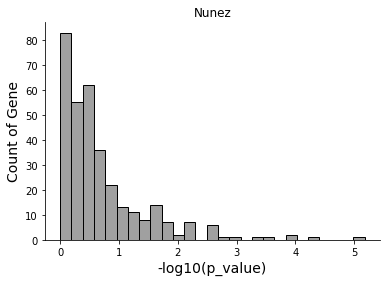

In [15]:
graph_pathout = '../Figure/Figure 3/Individual Figures/'
plt.xlabel('', fontsize=14)
ax = sns.histplot(results_nunez['-log10(p_value)'], color = 'grey')
ax.set_title('Sense vs Antisense', fontsize=20)
ax.set_ylabel('Count of Gene', fontsize=14)
sns.despine()
plt.title('Nunez')

plt.savefig(graph_pathout + "nunezOrientation.pdf", dpi=300, bbox_inches='tight')


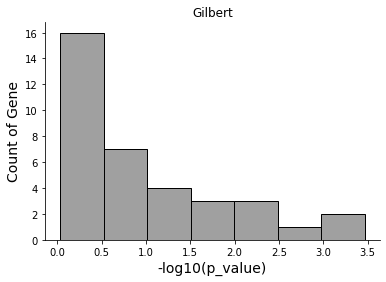

In [16]:
plt.xlabel('', fontsize=14)
ax = sns.histplot(results_gilbert['-log10(p_value)'], color = 'grey')
ax.set_title('Sense vs Antisense', fontsize=20)
ax.set_ylabel('Count of Gene', fontsize=14)
sns.despine()
plt.title('Gilbert')

plt.savefig(graph_pathout + "gilbertOrientation.pdf", dpi=300, bbox_inches='tight')


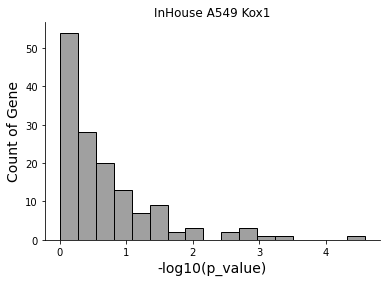

In [17]:
plt.xlabel('', fontsize=14)
ax = sns.histplot(results_inhouseA549Kox1['-log10(p_value)'], color = 'grey')
ax.set_title('Sense vs Antisense', fontsize=20)
ax.set_ylabel('Count of Gene', fontsize=14)
sns.despine()
plt.title('InHouse A549 Kox1')

plt.savefig(graph_pathout + "inhouseA549Kox1Orientation.pdf", dpi=300, bbox_inches='tight')


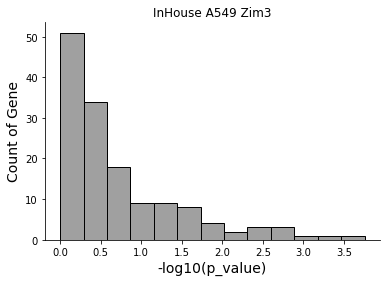

In [18]:
plt.xlabel('', fontsize=14)
ax = sns.histplot(results_inhouseA549Zim3['-log10(p_value)'], color = 'grey')
ax.set_title('Sense vs Antisense', fontsize=20)
ax.set_ylabel('Count of Gene', fontsize=14)
sns.despine()
plt.title('InHouse A549 Zim3')

plt.savefig(graph_pathout + "inhouseA549Zim3Orientation.pdf", dpi=300, bbox_inches='tight')


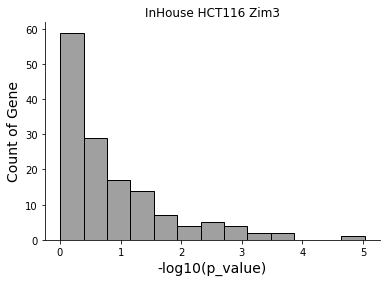

In [19]:
plt.xlabel('', fontsize=14)
ax = sns.histplot(results_inhouseHCT116Zim3['-log10(p_value)'], color = 'grey')
ax.set_title('Sense vs Antisense', fontsize=20)
ax.set_ylabel('Count of Gene', fontsize=14)
sns.despine()
plt.title('InHouse HCT116 Zim3')

plt.savefig(graph_pathout + "inhouseHCT116Zim3Orientation.pdf", dpi=300, bbox_inches='tight')


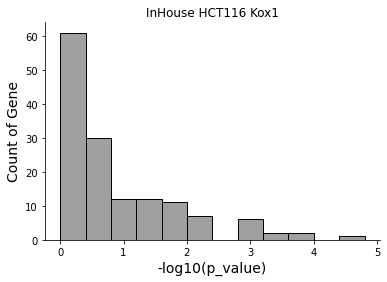

In [20]:
plt.xlabel('', fontsize=14)
ax = sns.histplot(results_inhouseHCT116Kox1['-log10(p_value)'], color = 'grey')
ax.set_title('Sense vs Antisense', fontsize=20)
ax.set_ylabel('Count of Gene', fontsize=14)
sns.despine()
plt.title('InHouse HCT116 Kox1')
plt.savefig(graph_pathout + "inhouseHCT116Kox1Orientation.pdf", dpi=300, bbox_inches='tight')


In [36]:
results_nunez = mann_whitney_u_per_gene(NewDatasetCombine_strand_avg[NewDatasetCombine_strand_avg.DataSet == 'Nunez'])
results_nunez['Dataset'] = 'Nunez'
results_gilbert = mann_whitney_u_per_gene(NewDatasetCombine_strand_avg[NewDatasetCombine_strand_avg.DataSet == 'Gilbert'])
results_gilbert['Dataset'] = 'Gilbert'
results_inhouse = mann_whitney_u_per_gene(NewDatasetCombine_strand_avg[NewDatasetCombine_strand_avg.DataSet == 'InHouse'])
results_inhouse['Dataset'] = 'InHouse'

plot_df = pd.concat([results_nunez,
                     results_gilbert,
                     results_inhouse])
plot_df

NIP7 does not satisify the sample size
SNW1 does not satisify the sample size


,gene,metrics_Orientation1,metrics_Orientation2,p_value,-log10(p_value),Dataset
0,ACTR6,++,+-,0.777052,0.109550,Nunez
1,AFG3L2,--,-+,0.079890,1.097510,Nunez
2,ANAPC13,-+,--,0.608246,0.215921,Nunez
3,AP2M1,+-,++,0.002114,2.674822,Nunez
4,ATP1A1,++,+-,0.259274,0.586241,Nunez
...,...,...,...,...,...,...
139,WEE1,+-,++,0.595892,0.224832,InHouse
140,YAE1,++,+-,0.070957,1.149007,InHouse
141,YEATS4,+-,++,0.185439,0.731798,InHouse
142,YY1,+-,++,0.000417,3.380166,InHouse


In [37]:
def categorize_pval(df, col= '-log10(pval)'):
    new_df = df.copy()
    conditions  = [ new_df[col] < 1, 
                   (new_df[col] >= 1) & (new_df[col]< 2), 
                   (new_df[col] >= 2) & (new_df[col]< 3), 
                   (new_df[col] >= 3) & (new_df[col]< 4),
                  new_df[col] >= 4]
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    new_df["-log10(pval) bins"] = np.select(conditions, choices, default=np.nan)
    return new_df

In [38]:
plot_df = categorize_pval(plot_df,col='-log10(p_value)')
plot_df

,gene,metrics_Orientation1,metrics_Orientation2,p_value,-log10(p_value),Dataset,-log10(pval) bins
0,ACTR6,++,+-,0.777052,0.109550,Nunez,< 1
1,AFG3L2,--,-+,0.079890,1.097510,Nunez,"[1,2)"
2,ANAPC13,-+,--,0.608246,0.215921,Nunez,< 1
3,AP2M1,+-,++,0.002114,2.674822,Nunez,"[2,3)"
4,ATP1A1,++,+-,0.259274,0.586241,Nunez,< 1
...,...,...,...,...,...,...,...
139,WEE1,+-,++,0.595892,0.224832,InHouse,< 1
140,YAE1,++,+-,0.070957,1.149007,InHouse,"[1,2)"
141,YEATS4,+-,++,0.185439,0.731798,InHouse,< 1
142,YY1,+-,++,0.000417,3.380166,InHouse,"[3,4)"


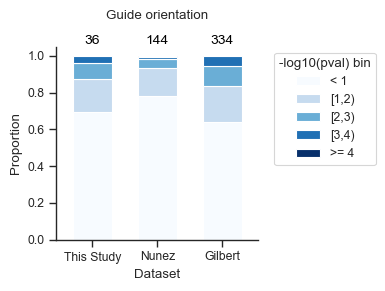

In [56]:
graph_pathout = '../Figure/Figure 3/Individual Figures/'

grouped_df = plot_df.groupby(['-log10(pval) bins', 'Dataset'])['gene'].nunique().reset_index()
grouped_df['Dataset'] = grouped_df['Dataset'].replace('InHouse','This Study')
grouped_df['total_gene'] = grouped_df.groupby('Dataset')['gene'].transform('sum')
grouped_df['prop_in_bin'] = grouped_df['gene']/grouped_df['total_gene']
grouped_df_pivoted = grouped_df.pivot(index = 'Dataset', columns = '-log10(pval) bins', values = 'prop_in_bin')
grouped_df_pivoted = grouped_df_pivoted[['< 1','[1,2)',  '[2,3)','[3,4)','>= 4']]
grouped_df_pivoted = grouped_df_pivoted.loc[['This Study','Nunez','Gilbert']]

fig, ax = plt.subplots(figsize=(4, 3))

grouped_df_pivoted.plot(kind='bar', stacked=True, ax=ax, width=0.6, cmap = 'Blues')

# Add percentages to the bars and the total count
num_gene_dataset = grouped_df[['Dataset','total_gene']].drop_duplicates()
for i in range(len(num_gene_dataset)):
    dataset = num_gene_dataset.iloc[i]['Dataset']
    num_gene = num_gene_dataset.iloc[i]['total_gene']
    ax.text(i, 1.05, f'{int(num_gene)}', ha='center', va='bottom', fontsize=10, fontweight='light', color='black')


plt.ylabel('Proportion')
plt.xlabel('Dataset')
plt.xticks(rotation=0)
plt.title('Guide orientation',pad=20)
plt.legend(title='-log10(pval) bin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine()
gpp.savefig(graph_pathout + "orientation_combined.pdf", dpi=300, bbox_inches='tight')